# Take eddy that collocated to bird data and find complete eddy history
- Read in collocated bird data
- Read in AVISO eddy database subset for NPac
- find unique eddies in bird data
- find all AVISO eddy for that eddy ID
- create new dataset with track number and observation number as dims
- save eddy data into it

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 
from geopy.distance import geodesic 
from pyresample.kd_tree import resample_nearest
from scipy import spatial

####################you will need to change some paths here!#####################
#list of input files
#list of input files

filename_aviso='F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106.nc'   #From AVISO  website
filename_bird_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc'
#################################################################################
filename_origin='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info.nc'

# read in collocated bird data

In [10]:
ds_bird = xr.open_dataset(filename_bird_netcdf)
ds_bird

<xarray.Dataset>
Dimensions:                 (index: 92738)
Coordinates:
  * index                   (index) int64 0 1 2 3 4 ... 92734 92735 92736 92737
Data variables:
    Unnamed: 0              (index) int64 ...
    Master.Key              (index) object ...
    Modified.Platform.Type  (index) object ...
    Fly.Bird.Method         (index) object ...
    Year                    (index) int64 ...
    Month                   (index) int64 ...
    Day                     (index) int64 ...
    Julian.Date             (index) int64 ...
    Sample.Area             (index) float64 ...
    PI.Credit               (index) object ...
    lon                     (index) float64 ...
    lat                     (index) float64 ...
    ANMU                    (index) int64 ...
    ARTE                    (index) int64 ...
    BLKI                    (index) int64 ...
    BOGU                    (index) int64 ...
    CAAU                    (index) int64 ...
    CAGU                    (index) int64 ...
    COLO                    (index) int64 ...
    CRAU                    (index) int64 ...
    DCCO                    (index) int64 ...
    FTSP                    (index) int64 ...
    GWGU                    (index) int64 ...
    HERG                    (index) int64 ...
    HOPU                    (index) int64 ...
    LEAU                    (index) int64 ...
    LESP                    (index) int64 ...
    MEGU                    (index) int64 ...
    NOFU                    (index) int64 ...
    PAAU                    (index) int64 ...
    PALO                    (index) int64 ...
    PIGU                    (index) int64 ...
    RHAU                    (index) int64 ...
    SAGU                    (index) int64 ...
    TUPU                    (index) int64 ...
    WHAU                    (index) int64 ...
    ALLSH                   (index) int64 ...
    ALLMU                   (index) int64 ...
    ALLBRMU                 (index) int64 ...
    GACO                    (index) int64 ...
    ALLALB                  (index) int64 ...
    ALLPE                   (index) int64 ...
    ALLJA                   (index) int64 ...
    time                    (index) datetime64[ns] ...
    amplitude               (index) float32 ...
    cyclonic_type           (index) float64 ...
    lat_eddy                (index) float32 ...
    lon_eddy                (index) float32 ...
    observation_number      (index) float64 ...
    speed_average           (index) float32 ...
    speed_radius            (index) float32 ...
    track                   (index) float64 ...
    time64                  (index) datetime64[ns] ...
    save_eddy_distance      (index) float32 ...
    aviso_adt               (index) float64 ...
    aviso_sla               (index) float64 ...
    aviso_ugos              (index) float64 ...
    aviso_ugosa             (index) float64 ...
    aviso_vgos              (index) float64 ...
    aviso_vgosa             (index) float64 ...
    ccmp_uwnd               (index) float32 ...
    ccmp_vwnd               (index) float32 ...
    cmc_sst                 (index) float32 ...
    ETOPO_depth             (index) float64 ...

# open aviso eddy dataset

<xarray.Dataset>
Dimensions:             (obs: 334732)
Coordinates:
  * obs                 (obs) int64 0 1 2 3 4 ... 334728 334729 334730 334731
Data variables:
    amplitude           (obs) float32 ...
    cyclonic_type       (obs) float64 ...
    lat                 (obs) float32 48.0161 47.9866 ... 47.7512 47.7305
    lon                 (obs) float32 -128.318 -128.357 ... -141.957 -141.965
    observation_number  (obs) float64 ...
    speed_average       (obs) float32 ...
    speed_radius        (obs) float32 ...
    time                (obs) object ...
    track               (obs) float64 ...
    time64              (obs) datetime64[ns] ...
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0

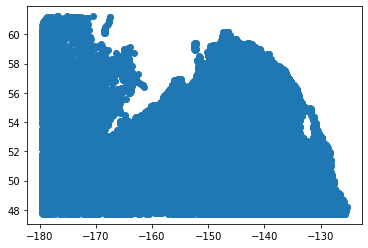

In [13]:

ds_eddy = xr.open_dataset('F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_northpac.nc')
ilen_eddy = len(ds_eddy.lat)
plt.scatter(ds_eddy.lon,ds_eddy.lat)
ds_eddy

# Create xarray dataset structure to hold data

In [98]:
ds2 = ds_bird.where(ds_bird.track>1,drop=True)
all_tracks = np.unique(ds2.track.data)
ilen = len(all_tracks)
inum_obs = int(ds_eddy.observation_number.max().data)+1
iobs = np.arange(inum_obs)
print(ilen,inum_obs)
da=xr.DataArray(np.nan*np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy['amplitude'].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))
ds_tem = xr.Dataset({'amplitude':da})
for var in ds_eddy:
    if (var!='observation_number') & (var!='track') & (var!='time') & (var!='time64') & (var!='amplitude'):
        da=xr.DataArray(np.nan*np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy[var].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))

        ds_tem[var]=da
    if (var=='time64'):
        da=xr.DataArray(np.empty((ilen,inum_obs), 
                                dtype=str(ds_eddy[var].dtype)), 
                coords={'track': all_tracks.astype('int'),'observation_number':np.arange(inum_obs)}, 
                dims=('track','observation_number'))

        ds_tem[var]=da
ds_tem

765 1331


<xarray.Dataset>
Dimensions:             (observation_number: 1331, track: 765)
Coordinates:
  * track               (track) int32 4438 4918 5213 ... 270829 270892 271234
  * observation_number  (observation_number) int32 0 1 2 3 ... 1328 1329 1330
Data variables:
    amplitude           (track, observation_number) float32 nan nan ... nan nan
    cyclonic_type       (track, observation_number) float64 nan nan ... nan nan
    lat                 (track, observation_number) float32 nan nan ... nan nan
    lon                 (track, observation_number) float32 nan nan ... nan nan
    speed_average       (track, observation_number) float32 nan nan ... nan nan
    speed_radius        (track, observation_number) float32 nan nan ... nan nan
    time64              (track, observation_number) datetime64[ns] 1970-01-01 ... 1970-01-01

# go through all unique eddies and save data into structure
- save variable attributes
- save global attributes

In [102]:
for ii,idn in enumerate(ds_tem.track.data):
    subset = ds_eddy.where(ds_eddy.track.astype('int')==idn,drop=True)
    for var in subset:
        if (var!='observation_number') & (var!='track') & (var!='time') & (var!='amplitude'):
            ilen_obs = len(subset.obs)
            ds_tem[var][ii,:ilen_obs]=subset[var][:].data
            ds_tem[var].attrs=subset[var].attrs
    if subset.observation_number[0].data>0:
        print(ii,subset.observation_number[0])
ds_tem.attrs = ds_eddy.attrs
ds_tem.to_netcdf(filename_origin)

0 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 3276
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
1 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 3854
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
2 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 3945
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
3 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 4298
Attributes:
    Longname:     observation_number
    description:  observa

30 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 30247
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
31 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 30440
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
32 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 30952
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
33 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 31857
Attributes:
    Longname:     observation_number
    description: 

60 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 49240
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
61 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 49279
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
62 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 49567
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
63 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 49635
Attributes:
    Longname:     observation_number
    description: 

90 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 63121
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
91 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 63320
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
92 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 63374
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
93 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 63498
Attributes:
    Longname:     observation_number
    description: 

120 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 73393
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
121 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 73675
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
122 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 73762
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
123 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 74124
Attributes:
    Longname:     observation_number
    descripti

151 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 85601
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
152 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 85939
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
153 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 86259
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
154 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 86370
Attributes:
    Longname:     observation_number
    descripti

181 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 96285
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
182 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 96375
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
183 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 96671
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
184 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 96727
Attributes:
    Longname:     observation_number
    descripti

211 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 108878
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
212 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 109313
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
213 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 111027
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
214 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 111055
Attributes:
    Longname:     observation_number
    descr

241 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 119652
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
242 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 121760
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
243 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 121828
Attributes:
    Longname:     observation_number
    description:  observation sequence number, days from eddy start
    units:        ordinal
    min:          0
    max:          2196
244 <xarray.DataArray 'observation_number' ()>
array(0.)
Coordinates:
    obs      int64 121904
Attributes:
    Longname:     observation_number
    descr

KeyboardInterrupt: 